## Random sample imputation

Taking random observations from the pool of available data and using them to replace the NA

Can be applied to both numerical and categorical vars

#### Assumptions

- Data is **missing completely at random**

#### Advantages

- Preserves the variable distribution

#### Limitation

- Randomness

- The relationship of imputed vars with other vars may be affected

- Memory heavy, as we need to keep a copy of the training set, to extract values to replace NA

#### When to use

- Data is **missing completely at random**

- <= 5% of the variables contain missing data

- Good for linear models as it does not distort the distribution, regardless of the percentage of NA

#### Important note

Because we will impute the missing data with random samples from the dataset. We need to control the randomness, forget to give a random seed may badly affect our result. Let take some examples:

- Consider we need to build a model to predict the time in garage for a car for inspection. There are missing values for a var. And we randomly pick a value from the pool to impute. Then our model made a prediction. Tomorrow, someone run the model again, and that time, another random value will be pick, that make the model predict another result for the same car eventhough nothing changed for the car.

- For the same car example as aboved. If there is another with the same specs, everything is exactly same between 2 of our cars. But 1 car was imputed with a random value, and the other with the other values. Our model would predict 2 different results eventhough our cars are exactly the same!

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3
SPLIT_RANDOM_STATE = 44
IMPUTATION_RANDOM_STATE = 68

In [2]:
data = pd.read_csv("../data/titanic.csv", usecols=["age", "fare", "survived"])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# proportion of na
data.isna().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

In [6]:
# Split dataset into train/test sets before learning
# (imputation is learning in tearm of statistical info of the dataset)
# , to avoid data leakage

X_train, X_test, y_train, y_test = train_test_split(
    data.drop("survived", axis=1),
    data["survived"],
    test_size=TEST_SIZE,
    random_state=SPLIT_RANDOM_STATE
)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [7]:
# impute by random sample
X_train["age_imputed"] = X_train["age"].copy()
X_test["age_imputed"] = X_test["age"].copy()

# train isna mask
train_is_na_mask = X_train["age"].isna()
# test isna mask
test_is_na_mask = X_test["age"].isna()
# number of sample needed for X_train
n_train_sample = train_is_na_mask.sum()
# number of sample needed for X_test
n_test_sample = test_is_na_mask.sum()

random_sample_train = (
    X_train["age"].dropna().sample(n_train_sample, random_state=IMPUTATION_RANDOM_STATE)
)

random_sample_test = (
    X_train["age"].dropna().sample(n_test_sample, random_state=IMPUTATION_RANDOM_STATE)
)

random_sample_train.index = X_train[train_is_na_mask].index
random_sample_test.index = X_test[test_is_na_mask].index

# replace na with newly created variable
X_train.loc[train_is_na_mask, "age_imputed"] = random_sample_train
X_test.loc[test_is_na_mask, "age_imputed"] = random_sample_test


In [8]:
X_train["age_imputed"].isna().sum()

np.int64(0)

In [9]:
X_test["age_imputed"].isna().sum()

np.int64(0)

In [11]:
X_train.head(15)

,age,fare,age_imputed
689,22.00,7.2500,22.00
376,24.00,10.5000,24.00
658,0.75,19.2583,0.75
255,24.00,69.3000,24.00
549,3.00,18.7500,3.00
1049,20.00,15.7417,20.00
723,31.00,7.7333,31.00
568,18.50,13.0000,18.50
1268,NaN,9.5000,21.00
266,56.00,26.5500,56.00


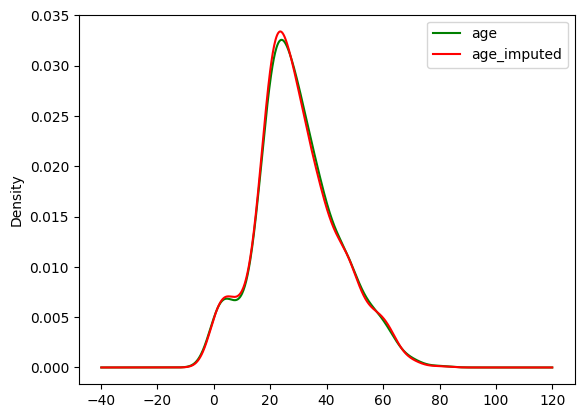

In [12]:
# See if random sampling preserves the original distribution of the variable
fig, ax = plt.subplots()
X_train["age"].plot(kind="kde", ax=ax, color="green")
X_train["age_imputed"].plot(kind="kde", ax=ax, color="red")
ax.legend()

In [ ]:
# Check variance after imputation, not change much
print("Before imputation variance: ", X_train["age"].var())
print("After imputation variance: ", X_train["age_imputed"].var())

Before imputation variance:  201.87433431318317
After imputation variance:  201.5994030698206


In [ ]:
# Check covariance, it was less than other technique from 1-7
X_train[["fare", "age", "age_imputed"]].cov()

,fare,age,age_imputed
fare,2881.253629,141.005360,107.701911
age,141.005360,201.874334,201.874334
age_imputed,107.701911,201.874334,201.599403


<Axes: >

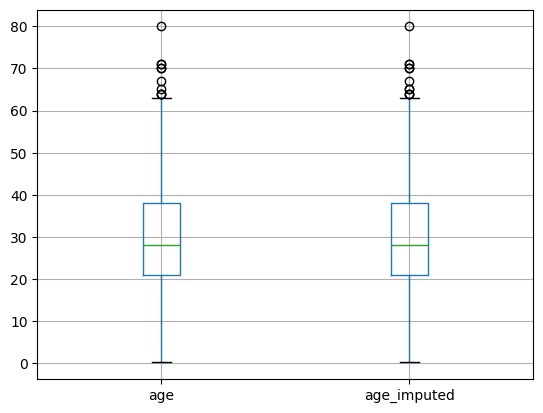

In [15]:
# How about ouliers?
X_train[["age", "age_imputed"]].boxplot()

### Controlling the element of randomness by varying the seed

We can attribute a different seed to each observation, and in fact, we can make this seed depend on an alternative variable of the same observation, thus, thinking in the Titanic dataset, if 2 passengers paid exactly the same Fare, they would get exactly the same probability of survival (when Age is missing).

In [16]:
# let's pick one observation with NA in Age
# in this case we pick observation indexed 15

observation = data[data.age.isnull()].head(1)
observation

,survived,age,fare
15,0,NaN,25.925


In [17]:
# the seed is now the Fare

int(observation.fare.iloc[0])

25

In [18]:
# we assign the Fare as the seed in the random sample extraction
sampled_value = X_train["age"].dropna().sample(1, random_state=int(observation.fare.iloc[0]))

sampled_value.index = [15]

observation["Age_random"] = sampled_value
observation

,survived,age,fare,Age_random
15,0,NaN,25.925,40.0


In [19]:
# for a different observation with a different Fare,
# we would get a different randomly extracted value

observation = data[data.age.isnull()].tail(1)

observation

,survived,age,fare
1305,0,NaN,14.4542


In [20]:
# new seed
int(observation.fare.iloc[0])

14

In [21]:
# we assign the Fare as the seed in the random sample extraction
sampled_value = X_train.age.dropna().sample(1, random_state=int(observation.fare.iloc[0]))

sampled_value.index = [1305]

observation["Age_random"] = sampled_value
observation

,survived,age,fare,Age_random
1305,0,NaN,14.4542,27.0


This is a way of controlling the randomness. Using the fare to set the random state, we guarantee that for 2 passengers with an equal fare, the age will be replaced with the same number, and therefore, the 2 passengers will get the same probability of survival.

### Note!!

In real life, we will build models that use tens of variables or more. So, in cases like that, we
 can think of picking the 3-5 most important variables, those that have the strongest impact on the output of the machine learning model, and combining them to create the random state. Therefore, customers that share the 3-5 main variable values, will get the same scores.